In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:

def see_neurons(A, ax, show=False):
    """
    Visualizes the connectivity matrix.
  
    Args:
      A (np.ndarray): the connectivity matrix of shape (n_neurons, n_neurons)
      ax (plt.axis): the matplotlib axis to display on
  
    Returns:
      Nothing, but visualizes A.
    """
    A = A.T  # make up for opposite connectivity
    n = len(A)
    ax.set_aspect('equal')
    thetas = np.linspace(0, np.pi * 2, n, endpoint=False)
    x, y = np.cos(thetas), np.sin(thetas),
    ax.scatter(x, y, c='k', s=150)

    # Renormalize
    A = A / A.max()
    for i in range(n):
        for j in range(n):
            if A[i, j] > 0:
                ax.arrow(x[i], y[i], x[j] - x[i], y[j] - y[i], color='k', alpha=A[i, j],
                         head_width=.15, width = A[i, j] / 25, shape='right',
                         length_includes_head=True)
    ax.axis('off')
    if show:
        plt.show()


def plot_connectivity_matrix(A, ax=None, show=False):
    """Plot the (weighted) connectivity matrix A as a heatmap
  
      Args:
        A (ndarray): connectivity matrix (n_neurons by n_neurons)
        ax: axis on which to display connectivity matrix
    """
    if ax is None:
        ax = plt.gca()
    lim = np.abs(A).max()
    im = ax.imshow(A, vmin=-lim, vmax=lim, cmap="coolwarm")
    ax.tick_params(labelsize=10)
    ax.xaxis.label.set_size(15)
    ax.yaxis.label.set_size(15)
    cbar = ax.figure.colorbar(im, ax=ax, ticks=[0], shrink=.7)
    cbar.ax.set_ylabel("Connectivity Strength", rotation=90,
                       labelpad= 20,va="bottom")
    ax.set(xlabel="Connectivity from", ylabel="Connectivity to")
    if show:
        plt.show()


def plot_connectivity_graph_matrix(A):
    """Plot both connectivity graph and matrix side by side
  
      Args:
        A (ndarray): connectivity matrix (n_neurons by n_neurons)
    """
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    see_neurons(A, axs[0])  # we are invoking a helper function that visualizes the connectivity matrix
    plot_connectivity_matrix(A)

    fig.suptitle("Neuron Connectivity")
    plt.show()


def plot_neural_activity(X):
    """Plot first 10 timesteps of neural activity
  
    Args:
      X (ndarray): neural activity (n_neurons by timesteps)
  
    """
    f, ax = plt.subplots()
    im = ax.imshow(X[:, :10])
    divider = make_axes_locatable(ax)
    cax1 = divider.append_axes("right", size="5%", pad=0.15)
    plt.colorbar(im, cax=cax1)
    ax.set(xlabel='Timestep', ylabel='Neuron', title='Simulated Neural Activity')
    plt.show()


def plot_true_vs_estimated_connectivity(estimated_connectivity, true_connectivity, selected_neuron=None):
    """Visualize true vs estimated connectivity matrices
  
    Args:
      estimated_connectivity (ndarray): estimated connectivity (n_neurons by n_neurons)
      true_connectivity (ndarray): ground-truth connectivity (n_neurons by n_neurons)
      selected_neuron (int or None): None if plotting all connectivity, otherwise connectivity
        from selected_neuron will be shown
  
    """

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    if selected_neuron is not None:
        plot_connectivity_matrix(np.expand_dims(estimated_connectivity, axis=1),
                                 ax=axs[0])
        plot_connectivity_matrix(true_connectivity[:, [selected_neuron]], ax=axs[1])
        axs[0].set_xticks([0])
        axs[1].set_xticks([0])
        axs[0].set_xticklabels([selected_neuron])
        axs[1].set_xticklabels([selected_neuron])
    else:
        plot_connectivity_matrix(estimated_connectivity, ax=axs[0])
        plot_connectivity_matrix(true_connectivity, ax=axs[1])

    axs[1].set(title="True connectivity")
    axs[0].set(title="Estimated connectivity")
    plt.show()

In [5]:
def neuron_B(activity_of_A):
    """Model activity of neuron B as neuron A activity + noise
  
    Args:
      activity_of_A (ndarray): An array of shape (T,) containing the neural activity of neuron A
  
    Returns:
      ndarray: activity of neuron B
    """
    noise = np.random.randn(activity_of_A.shape[0])

    return activity_of_A + noise

np.random.seed(12)

# Neuron A activity of zeros
A_0 = np.zeros(5000)

# Neuron A activity of ones
A_1 = np.ones(5000)

diff_in_means = np.mean(neuron_B(A_1)) - np.mean(neuron_B(A_0))
print(diff_in_means)

0.9907195190159408


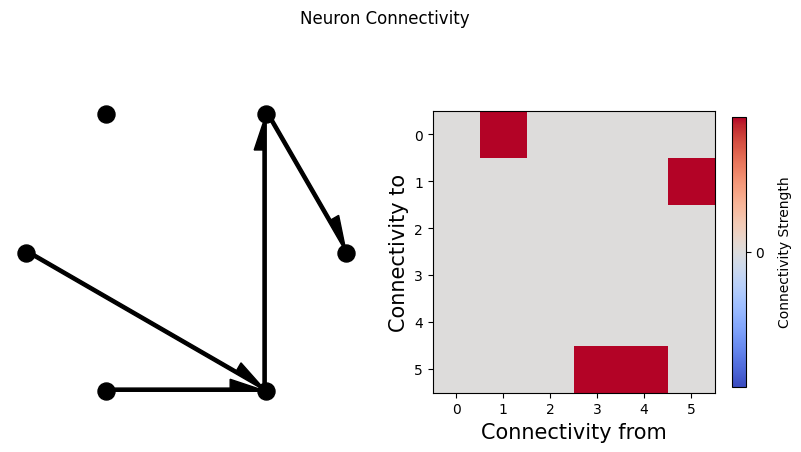

In [7]:
def create_connectivity(n_neurons, random_state=42):
    """
    Generate our nxn causal connectivity matrix.
  
    Args:
      n_neurons (int): the number of neurons in our system.
      random_state (int): random seed for reproducibility
  
    Returns:
      A (np.ndarray): our 0.1 sparse connectivity matrix
    """
    np.random.seed(random_state)
    A_0 = np.random.choice([0, 1], size=(n_neurons, n_neurons), p=[0.9, 0.1])

    # set the timescale of the dynamical system to about 100 steps
    _, s_vals, _ = np.linalg.svd(A_0)
    A = A_0 / (1.01 * s_vals[0])

    # _, s_val_test, _ = np.linalg.svd(A)
    # assert s_val_test[0] < 1, "largest singular value >= 1"

    return A


# Initializes the system
n_neurons = 6
A = create_connectivity(n_neurons)

# Let's plot it!
plot_connectivity_graph_matrix(A)

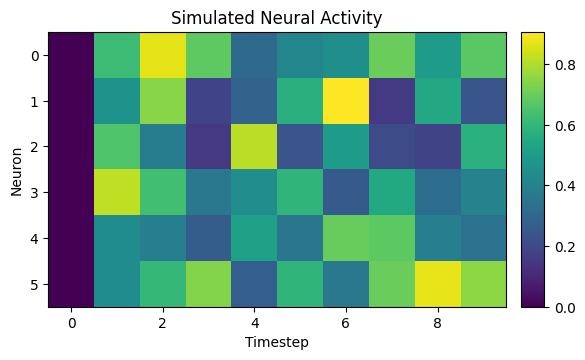

In [9]:
def sigmoid(x):
    """
    Compute sigmoid nonlinearity element-wise on x
  
    Args:
        x (np.ndarray): the numpy data array we want to transform
    Returns
        (np.ndarray): x with sigmoid nonlinearity applied
    """
    return 1 / (1 + np.exp(-x))

def simulate_neurons(A, timesteps, random_state=42):
    """Simulates a dynamical system for the specified number of neurons and timesteps.
  
    Args:
      A (np.array): the connectivity matrix
      timesteps (int): the number of timesteps to simulate our system.
      random_state (int): random seed for reproducibility
  
    Returns:
      - X has shape (n_neurons, timeteps). A schematic:
                  ___t____t+1___
      neuron  0  |   0    1     |
                |   1    0     |
      neuron  i  |   0 -> 1     |
                |   0    0     |
                |___1____0_____|
    """
    np.random.seed(random_state)

    n_neurons = len(A)
    X = np.zeros((n_neurons, timesteps))

    for t in range(timesteps - 1):

        # Create noise vector
        epsilon = np.random.multivariate_normal(np.zeros(n_neurons), np.eye(n_neurons))

        # Update activity vector for next step
        X[:, t + 1] = sigmoid(A @ X[:, t] + epsilon)  # we are using helper function sigmoid

    return X


# Set simulation length
timesteps = 5000

# Simulate our dynamical system
X = simulate_neurons(A, timesteps)

# Visualize
plot_neural_activity(X)

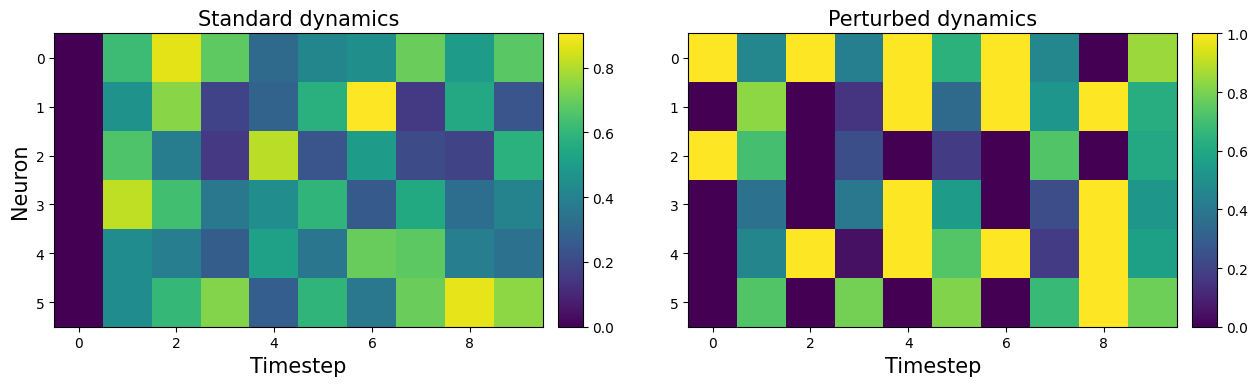

In [10]:
# @markdown Execute this cell to visualize perturbed dynamics
def simulate_neurons_perturb(A, timesteps):
    """
    Simulates a dynamical system for the specified number of neurons and timesteps,
    BUT every other timestep the activity is clamped to a random pattern of 1s and 0s
  
    Args:
      A (np.array): the true connectivity matrix
      timesteps (int): the number of timesteps to simulate our system.
  
    Returns:
      The results of the simulated system.
      - X has shape (n_neurons, timeteps)
    """
    n_neurons = len(A)
    X = np.zeros((n_neurons, timesteps))
    for t in range(timesteps - 1):
        if t % 2 == 0:
            X[:, t] = np.random.choice([0, 1], size=n_neurons)
        epsilon = np.random.multivariate_normal(np.zeros(n_neurons), np.eye(n_neurons))
        X[:, t + 1] = sigmoid(A.dot(X[:, t]) + epsilon)  # we are using helper function sigmoid

    return X


timesteps = 5000  # Simulate for 5000 timesteps.

# Simulate our dynamical system for the given amount of time
X_perturbed = simulate_neurons_perturb(A, timesteps)

# Plot our standard versus perturbed dynamics
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
im0 = axs[0].imshow(X[:, :10])
im1 = axs[1].imshow(X_perturbed[:, :10])

# Matplotlib boilerplate code
divider = make_axes_locatable(axs[0])
cax0 = divider.append_axes("right", size="5%", pad=0.15)
plt.colorbar(im0, cax=cax0)

divider = make_axes_locatable(axs[1])
cax1 = divider.append_axes("right", size="5%", pad=0.15)
plt.colorbar(im1, cax=cax1)

axs[0].set_ylabel("Neuron", fontsize=15)
axs[1].set_xlabel("Timestep", fontsize=15)
axs[0].set_xlabel("Timestep", fontsize=15);
axs[0].set_title("Standard dynamics", fontsize=15)
axs[1].set_title("Perturbed dynamics", fontsize=15)
plt.show()

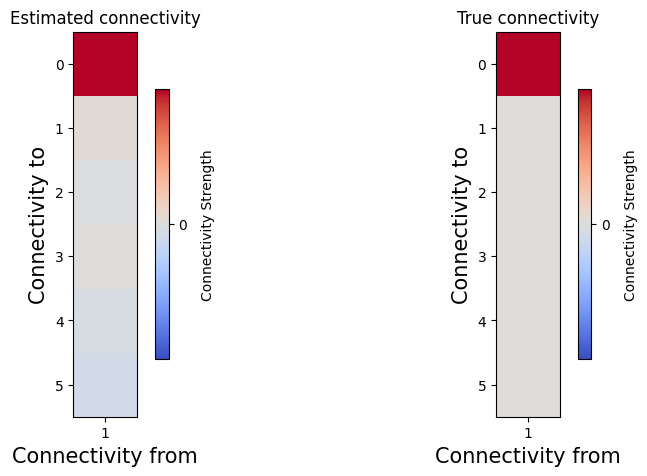

In [11]:
def get_perturbed_connectivity_from_single_neuron(perturbed_X, selected_neuron):
    """
    Computes the connectivity matrix from the selected neuron using differences in means.
  
    Args:
      perturbed_X (np.ndarray): the perturbed dynamical system matrix of shape
                                (n_neurons, timesteps)
      selected_neuron (int): the index of the neuron we want to estimate connectivity for
  
    Returns:
        estimated_connectivity (np.ndarray): estimated connectivity for the selected neuron,
                                             of shape (n_neurons,)
    """
    # Extract the perturbations of neuron 1 (every other timestep)
    neuron_perturbations = perturbed_X[selected_neuron, ::2]

    # Extract the observed outcomes of all the neurons (every other timestep)
    all_neuron_output = perturbed_X[:, 1::2]

    # Initialize estimated connectivity matrix
    estimated_connectivity = np.zeros(n_neurons)

    # Loop over neurons
    for neuron_idx in range(n_neurons):

        # Get this output neurons (neuron_idx) activity
        this_neuron_output = all_neuron_output[neuron_idx, :]

        # Get timesteps where the selected neuron == 0 vs == 1
        one_idx = np.argwhere(neuron_perturbations == 1)
        zero_idx = np.argwhere(neuron_perturbations == 0)

        difference_in_means = np.mean(this_neuron_output[one_idx]) - np.mean(this_neuron_output[zero_idx]) 

        estimated_connectivity[neuron_idx] = difference_in_means

    return estimated_connectivity


# Initialize the system
n_neurons = 6
timesteps = 5000
selected_neuron = 1

# Simulate our perturbed dynamical system
perturbed_X = simulate_neurons_perturb(A, timesteps)

# Measure connectivity of neuron 1
estimated_connectivity = get_perturbed_connectivity_from_single_neuron(perturbed_X, selected_neuron)
plot_true_vs_estimated_connectivity(estimated_connectivity, A, selected_neuron)

In [12]:
print(np.corrcoef(A[:, selected_neuron], estimated_connectivity)[1, 0])


0.9960188025389387


In [17]:
print("ground truth neuron connectivity vector (who am I connected to)?", A[:, selected_neuron])

ground truth neuron connectivity vector (who am I connected to)? [0.70010572 0.         0.         0.         0.         0.        ]


In [16]:
print("estimated connectivity: ", estimated_connectivity)

estimated connectivity:  [ 0.15409612  0.00372848 -0.00341909  0.00257458 -0.00661607 -0.01168013]


In [18]:
ground_truth = np.array([0.70010572, 0., 0., 0., 0., 0.])
estimated_connectivity = np.array([0.15409612, 0.00372848, -0.00341909, 0.00257458, -0.00661607, -0.01168013])

# Step 1: Calculate means
mean_ground_truth = np.mean(ground_truth)
mean_estimated = np.mean(estimated_connectivity)

print("Mean of ground truth:", mean_ground_truth)
print("Mean of estimated connectivity:", mean_estimated)

# Step 2: Subtract means
deviation_ground_truth = ground_truth - mean_ground_truth
deviation_estimated = estimated_connectivity - mean_estimated

print("Deviations from mean (ground truth):", deviation_ground_truth)
print("Deviations from mean (estimated):", deviation_estimated)

# Step 3: Multiply the deviations
product_deviations = deviation_ground_truth * deviation_estimated

print("Product of deviations:", product_deviations)

# Step 4: Sum of products
sum_product_deviations = np.sum(product_deviations)

print("Sum of product of deviations:", sum_product_deviations)

# Step 5: Square deviations
squared_deviation_ground_truth = deviation_ground_truth ** 2
squared_deviation_estimated = deviation_estimated ** 2

# Step 6: Sum of squared deviations
sum_squared_deviation_ground_truth = np.sum(squared_deviation_ground_truth)
sum_squared_deviation_estimated = np.sum(squared_deviation_estimated)

print("Sum of squared deviations (ground truth):", sum_squared_deviation_ground_truth)
print("Sum of squared deviations (estimated):", sum_squared_deviation_estimated)

# Step 7: Calculate correlation coefficient
correlation = sum_product_deviations / np.sqrt(sum_squared_deviation_ground_truth * sum_squared_deviation_estimated)

print("Correlation coefficient:", correlation)

# Verify with numpy's corrcoef function
print("Numpy's correlation coefficient:", np.corrcoef(ground_truth, estimated_connectivity)[0, 1])

Mean of ground truth: 0.11668428666666668
Mean of estimated connectivity: 0.02311398166666666
Deviations from mean (ground truth): [ 0.58342143 -0.11668429 -0.11668429 -0.11668429 -0.11668429 -0.11668429]
Deviations from mean (estimated): [ 0.13098214 -0.0193855  -0.02653307 -0.0205394  -0.02973005 -0.03479411]
Product of deviations: [0.07641779 0.00226198 0.00309599 0.00239663 0.00346903 0.00405993]
Sum of product of deviations: 0.09170134426499792
Sum of squared deviations (ground truth): 0.4084566826472654
Sum of squared deviations (estimated): 0.020752495328909076
Correlation coefficient: 0.9960188021446683
Numpy's correlation coefficient: 0.9960188021446682
